In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Oct 11 11:58:32 2022

@Author:     Alessio Borgi
@Contact :   borgi.1952442@studenti.uniroma1.it
             alessioborgi3@gmail.com
@Filename:   Spam_Detector.py

@Project_Field: NLP(Natural Language Processing)
@Project_Goal:  Classification of Emails in either Spam or Ham.
"""

''' #######       0° PART: LIBRARIES       #######'''

'''STEP 0: IMPORTING NEEDED LIBRARIES'''
import pandas as pd                                                     #Library that will be used for importing the data using Pandas Dataframes from a csv file.
import re                                                               #Library that will be used for sobstituting some strings in the Pre-Processing Step.
import string                                                           #Library that will be used during the Pre-Processing Step.
import numpy as np                                                      #Library that will be used for manipulation.
from sklearn.model_selection import train_test_split                    #Library that will be used in the Splitting-Step for doing the Train-Test Split.
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS          #Library that will be used for deleting stop words from the email in the Pre-processing step.
from sklearn.preprocessing import LabelEncoder                          #Library that will be used for creating a Label Encoder due to the necessity of providing numbers 
                                                                        #to the model as targets.
from keras.models import save_model                                     #Library that will be used for saving the Model once it is trained. 
from keras.preprocessing.text import Tokenizer                          #Library that will be used to Tokenize the emails.
from keras_preprocessing.sequence import pad_sequences                  #Library that will be used for the Padding of the Tokens.
from keras.layers import Dense, Input, LSTM, Embedding                  #Library that allows to import the LSTM Model.
from keras.layers import Bidirectional, Dropout, Activation             #Library that allows to import the various tools we can set onto the model.
from keras.models import Model                                          #Library that will be used for the Model.
import tensorflow as tf                                                 #Library that will be used for making neural nets.
from tensorflow import keras                                            #Library that will be used, more specific, for making neural nets.
import matplotlib.pyplot as plt                                         #Library that will be used for making some graphs.
from sklearn.metrics import confusion_matrix,f1_score                   #Library that will be use for making some statistics and computations on the result (post-processing).
from sklearn.metrics import precision_score,recall_score                #Library that will be use for making some statistics and computations on the result (post-processing).
import seaborn as sns                                                   #Library that will be used for making some graphs.


In [ ]:

''' #######       1° PART: FROM IMPORTING DATA TO PADDING IT       #######'''

'''STEP 1: IMPORTING THE DATA'''
''' 
    In this step I will make use of a pre-gathered dataset, downloaded from the UCI Machine Learning Repository at the following link:
    Dataset: http://archive.ics.uci.edu/ml/datasets/Spambase/
    
    I Import the Dataset from a cvs file. It is composed of two columns(features): Email and Label, i.e. the Email Text and its classification, respectively. 
    The Label is set to 1 if I have a Spam Email and to 0 if I have a Ham Email.
'''

#IMPORTING DATASET:
dataset = pd.read_csv('/content/drive/MyDrive/Colab/Dataset_SpamHam.csv')   #Importing the Dataset as a Pandas Dataframe.
# dataset = pd.read_csv('Dataset_SpamHam.csv')                            
# print(dataset.head())                                                     #Remove the comment to see the first 5 examples of the dataset.


'''STEP 2: SPLITTING THE DATA AND PRE-PROCESSING PIPELINE'''
'''
    In this step I first do the usual split in Training and Test Data and their correspective Labels.
    Once I have done this sub-step, I go through the Pre-Processing Step. Here I have to transform the raw data I received (data present in the UCI Dataset)
    into meaningful data. 
    As a first step of the PRE-PROCESSING I go through a cleaning of the data, modifying it. I perform the following transformations/modifications:
    - HYPERLINKS REMOVAL: I remove any hyperlink from the emails.
    - LOWERING LETTERS' CASE: I lower all the words in such a way to avoid to have more "versions" of the same word. 
    - PUNCTUATION REMOVAL: I remove punctuation (!,?, etc...), in such a way always to reach a sort of standardization in the words version.
    - STOP WORDS REMOVAL: I remove those words that are "neutral", like the articles "the", "a", etc..., since they do not provide important info.

    After this, I Create a Label Encoder in such a way to Encode Labels as numbers, since the model will expect the target variable in this way and 
    not as a string.
'''
#SPLITTING DATA:
emails_train, emails_test, target_train, target_test = train_test_split(dataset.Email,dataset.Label,test_size = 0.3) #Performing the 70-30 Data Split.
# print(dataset.info)                                                       #Printing the Dataset information.

#PRE-PROCESSING
def pre_process(word):
    '''Pre-Processing Function'''
    
    #HYPERLINKS REMOVAL & LOWERING LETTERS' CASE:
    word_without_hyper = re.sub('http\S+', '', word).lower()
    #PUNCTATION REMOVAL:
    word_without_punctuation = ((word_without_hyper.translate(str.maketrans(dict.fromkeys(string.punctuation)))).strip()).replace('\n', '')
    #STOP WORDS REMOVAL:
    f_word = ''.join([i for i in word_without_punctuation if i not in ENGLISH_STOP_WORDS])
    # print(f_word)
    
    return f_word                                                           #Returning the final pre-processed email.


#PRE-PROCESSING APPLICATION:
x_train = [pre_process(o) for o in emails_train]                            #Applying the Pre-Processing step to the Train Part.
x_test = [pre_process(o) for o in emails_test]                              #Applying the Pre-Processing step to the Test Part.

#LABELING ENCODER CREATION
label_encoder = LabelEncoder()                                              #Creation of the Label Encoder object.
train_label = label_encoder.fit_transform(target_train.values)              #Encoding of the Train Labels.
test_label = label_encoder.transform(target_test.values)                    #Encoding of the Test Labels.
# test_label = label_encoder.fit_transform(target_test.values)
# print(train_label)

'''STEP 3: TOKENIZING THE DATA'''
'''
    In this step I apply a very important step: Tokenization. Tokenizing consists in splitting text into smaller parts (a.k.a. Tokens) that are 
    fed to the Neural Net as a feature. This step will tokenize the text into tokens and it will keep only the words that occurs the most in the
    text. I let this decision vary by setting the "max_meaningful_words" variable, in such a way to be able to select the top frequent words to consider.
'''

#TOKENIZING:
max_meaningful_words = 70000                                                #I set how many meaningful words I want to keep into account, (i.e the number of rows in the 
                                                                            #Embedding Vector).
tokenizer = Tokenizer(num_words = max_meaningful_words)                     #Creation of the Tokenizer object with the maximum number of words to keep into account set.
tokenizer.fit_on_texts(x_train)                                             #Applying the tokenization to the Training Data.
x_train_features = np.array(tokenizer.texts_to_sequences(x_train))          #Transforming the Training data into an array.
# tokenizer.fit_on_texts(x_test)                                            #Applying the tokenization to the Training Data.
x_test_features = np.array(tokenizer.texts_to_sequences(x_test))            #Transforming the Test data into an array.

'''STEP 4: PADDING THE DATA'''
'''
    In this step I would like to reach a sort of Standardization under the size point of view. This means that, through this PADDING step, I will make 
    the tokens for all the emails ot have an equal size. This is useful, because when I send batches of data in input, information might be lost when 
    inputs are of different length. The length of all tokenized emails must be equal to the maximum length of the token.
'''

#PADDING:
max_padding = 2000                                                          #Maximum Padding variable to be set.
x_train_features = pad_sequences(x_train_features,maxlen=max_padding)       #Applying Padding to the Training Data.
x_test_features = pad_sequences(x_test_features,maxlen=max_padding)         #Applying Padding to the Test Data.
# print(x_train_features[0])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
''' #######       2° PART: MODEL IMPLEMENTATION AND TRAINING       #######'''

'''STEP 5: MODEL IMPLEMENTATION'''
'''
    For the Model Selection part, I have opted for a RNN, and in particular an LSTM, that allows me, thanks to its Memory, to keep into account also the 
    context of the words. Moreover, in order to perform LSTM even in reverse orde, I will make use of a Bi-Directional LSTM.
    
    As a first step, I need to convert my text data in Embedding. Then I can create the Neural Network Model.
    - Model Type: Bi-Directional LSTM
    - Activation Functions: SELU and SIGMOID
    - Loss Function: Log-Loss(Binary Cross-Entropy)
    - Optimizer: Adam
    - # Epochs: 20
    - Dropout Regularization: 0.1
'''

#EMBEDDING CREATION:
# create the model
embedding_vector_len = 32                                                   #I set the size of the Output Vector from each Layer of the LSTM.
model = tf.keras.Sequential()                                               #Creation of a Sequential Model.
model.add(Embedding(max_meaningful_words, embedding_vector_len,             #Creation of an Embedding Layer to be vectorized.
                    input_length=max_padding))
model.add(Bidirectional(tf.keras.layers.LSTM(16)))                          #Adding the Bi-Directional LSTM.

model.add(Dense(16, activation='relu'))                                   #We can set the activation function of the Model to be the RELU.
# model.add(Dense(8, activation='selu'))                                     #We can set the activation function of the Model to be the SELU.
model.add(Dropout(0.5))                                                     #Adding some Dropout, that allows to Regularize the Neural Network by dropping temporarily some 
                                                                            #nodes from the neural net at each epoch.
model.add(Dense(1, activation='sigmoid'))                                   #Adding the Sigmoid Activation Function to normalize the output, and thus see them as probabilities.
model.compile(loss='binary_crossentropy', optimizer='adam',                 #Setting the loss (LOG-LOSS or Binary-Cross entropy). I set the Optimizer to be the Adam one, 
               metrics=['accuracy'])                                        #since it is the best one (instead of using GD or others).
# print(model.summary())                                                    #Printing the Neural Network Summary.
description = model.fit(x_train_features, train_label, batch_size = 256,    #Setting teh Description of the Neural Network, indicating batch size, number of epochs.
                        epochs = 10, validation_data = 
                        (x_test_features, test_label))
model.save('/content/drive/MyDrive/Colab/Models/Spam_Detector_v_0.0.1_RELU_16_16_Dropout_0.5')     #Saving the Model into a location, in such a way to be able to load it after without re-training it.


Epoch 1/10
16/16 [==============================] - 50s 3s/step - loss: 0.6422 - accuracy: 0.8469 - val_loss: 0.5650 - val_accuracy: 0.8666
Epoch 2/10
16/16 [==============================] - 44s 3s/step - loss: 0.4775 - accuracy: 0.8662 - val_loss: 0.3583 - val_accuracy: 0.8666
Epoch 3/10
16/16 [==============================] - 45s 3s/step - loss: 0.3847 - accuracy: 0.8672 - val_loss: 0.3101 - val_accuracy: 0.8666
Epoch 4/10
16/16 [==============================] - 44s 3s/step - loss: 0.3072 - accuracy: 0.8703 - val_loss: 0.2281 - val_accuracy: 0.8666
Epoch 5/10
16/16 [==============================] - 43s 3s/step - loss: 0.2121 - accuracy: 0.9090 - val_loss: 0.1548 - val_accuracy: 0.9522
Epoch 6/10
16/16 [==============================] - 44s 3s/step - loss: 0.1463 - accuracy: 0.9597 - val_loss: 0.1110 - val_accuracy: 0.9731
Epoch 7/10
16/16 [==============================] - 44s 3s/step - loss: 0.1097 - accuracy: 0.9782 - val_loss: 0.0855 - val_accuracy: 0.9779
Epoch 8/10
16/16 [==

In [ ]:
model.save('/content/drive/MyDrive/Colab/Models/Spam_Detector_v_0.0.3')

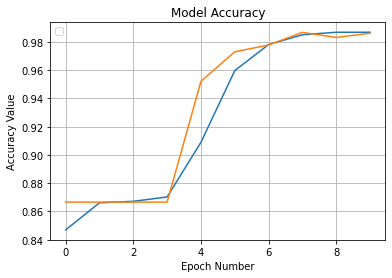

53/53 [==============================] - 13s 233ms/step
Precision: 99.50495%
Recall: 90.13453%
F1 Score: 94.58824%


0.9458823529411764

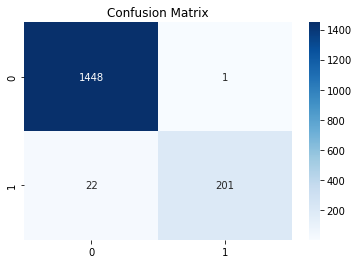

In [ ]:

''' #######       3° PART: PERFORMANCE REVISION       #######'''
'''
    In this step, I will focus on some performances measurments. Indeed, as Post-processing step, I need to know whether the Model I have built
    is effective or not. 
'''

'''STEP 6: REVISION: PERFORMANCE FOCUS'''
'''
    I will make use of the Accuracy, but also of other very important metrics, such as the Precision, the Recall and the F1 Score.
    While the Accuracy says to me effectively what is the percentage of guessing the right value for the Email (Spam VS Ham), I have the Precision
    to indicating the fraction of relevant nstances from all the relevant instances. Instead, the Recall, helps out to understand how complete the 
    results are.
    At the end, I have the F1 Score (that in practice is the harmonic mean of precision and recall).
'''

#ACCURACY VS EPOCHS:
plt.title('Model Accuracy')                                                 #Setting the Title of the Plot.
plt.ylabel('Accuracy Value')                                                #Setting the y label for the Plot.
plt.xlabel('Epoch Number')                                                  #Setting the x label for the Plot.
plt.legend(['train', 'test'], loc='upper left')                             #Setting the Legend to be in the upper left part of the plot.
plt.plot(description.history['accuracy'])                                   #Printing out the Training Data Accuracy.
plt.plot(description.history['val_accuracy'])                               #Printing out the Test Data Accuracy.
plt.grid()                                                                  #Adding a grid to the plot.
plt.show()                                                                  #Showing the plot.

#PREDICTING THE LABELS:
y_predict  = [1 if o > 0.5 else 0 for o in model.predict(x_test_features)]  #Predicting the labels for the test data.

#COMPUTING THE CONFUSION MATRIX:
conf_matrix = confusion_matrix(test_label,y_predict)                        #Computing the Confusion Matrix for the same data.

#GETTING ALL THE VALUES FROM CONFUSION MATRIX:  
#tn, fp, fn, tp = confusion_matrix(test_label,y_predict).ravel()             #Splitting the Confusion Matrix for seeing what are all the values( True Negative, Fase Positive, False Negative, True Positive).

#PLOTTING THE CONFUSION MATRIX:
ax= plt.subplot()                                                           #Creation of a subplot.
ax.set_title('Confusion Matrix')                                            #Setting the title.
ax.set_xlabel('Predicted labels')                                           #Setting the x label.
ax.set_ylabel('True labels')                                                #Setting the y label.
sns.heatmap(conf_matrix, annot = True, ax = ax,cmap='Blues',fmt='');        #Plotting out the Confusion Matrix.

#COMPUTING PRECISION, RECALL AND F1 SCORE
print("Precision: {:.5f}%".format(100 *                                     #Computing the Precision Score.
                                  precision_score(test_label, y_predict)))  
print("Recall: {:.5f}%".format(100 * recall_score(test_label, y_predict)))  #Computing the Recall Score.
print("F1 Score: {:.5f}%".format(100 * f1_score(test_label,y_predict)))     #Computing the F1 Score.
f1_score(test_label,y_predict)
